<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to your assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Alexander Li
- <b>Student ID:</b> 30630711 

<div class="alert alert-block alert-danger">

# Table of Contents

* [Libraries](#Libraries)
    
* [Task 3.1: Download the GTSRB Train and Test set](#t3_1)
    
* [Task 3.2: Visualise a few training samples](#t3_2)
    
* [Task 3.3: Define a CNN Model](#t3_3)
    
* [Task 3.4: Train and evaluate CNN model](#t3_4)
    
* [Task 3.5: Visualise the results](#t3_5)
    
* [Task 3.6: Discussion Questions](#t3_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [2]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# from carbontracker.tracker import CarbonTracker

from torch.optim.lr_scheduler import StepLR

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device

Global seed set to 4179


<div class="alert alert-block alert-info">
    
# Image Classification on the GTSRB dataset
    
# What you should do in this task!

In this task you will be training a Convolutional Neural Network (CNN) with the GTSRB dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the GTSRB dataset.
    
## In this task, you will work on the following points:
 1. Download the GTSRB Train and Test set
 2. Visualise a few training samples
 3. Define a CNN Model
 4. Train and evaluate CNN model
 5. Visualise the results and apply additional analysis here
 6. Discussion Questions

<img src="figures/GTSRB.jpg" width="700" align="center">

<div class="alert alert-block alert-info">
    
## Task 3.1: Download the GTSRB Train and Test set <a class="anchor" id="t3_1"></a>

The  German Traffic Sign Recognition Benchmark (GTSRB) is a a multi-class, single-image classification benchmark dataset. There are 43 classes in total, and more than over 50,000 images. There are 39,209 training examples, 12,630 test examples.

More about GTSRB dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Define transform to convert image into a Tensor
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Init Train DataLoader from GTSRB Dataset
train_ds = GTSRB(PATH_DATASETS, split="train", download=True, transform=transform)

# Perform Random Split for training and validation
train_ds, val_ds = random_split(train_ds, [int(len(train_ds)-math.floor(len(train_ds)*0.2)), math.ceil(int(len(train_ds)*0.2))])

val_loader = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Init Test DataLoader from GTSRB Dataset
test_ds = GTSRB(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Read the categories from the text file given: gtsrb_classes.txt
# This contains all 43 classes
with open(PATH_DATASETS + "/gtsrb_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# The code has been done for you in 3.1 

<div class="alert alert-block alert-info">
    
## Task 3.2: Visualise a few training samples <a class="anchor" id="t3_2"></a>
Let's first take a closer look at the shapes of the dataset, and then visualise the mini-batches that the dataloader gives us. Ensure you have reversed the normalization before plotting.

torch.Size([64, 3, 28, 28])


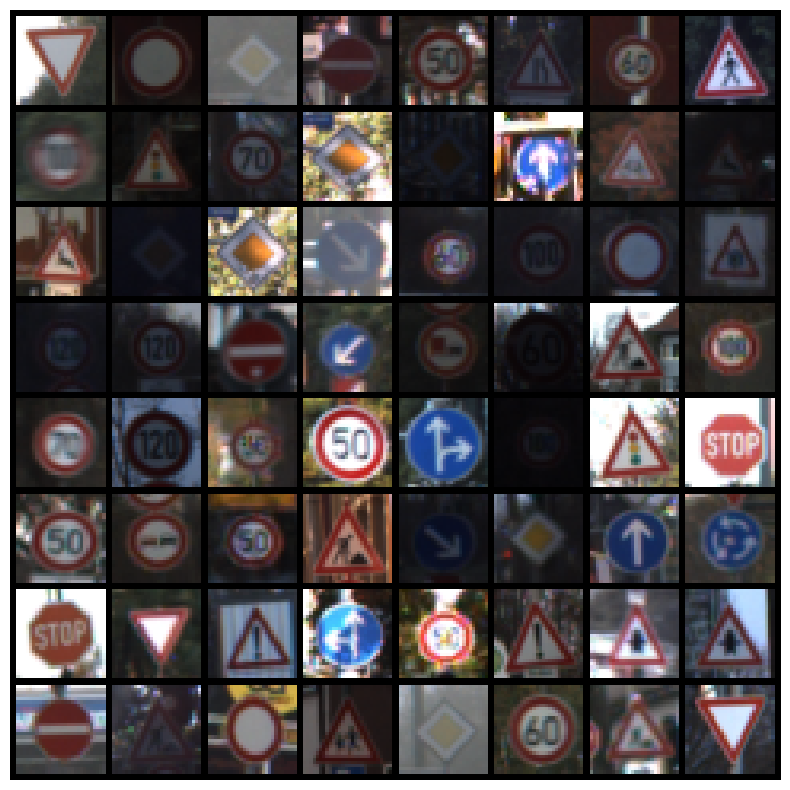

In [4]:
# Check the shapes of the batch data in train_loader
images, labels = next(iter(train_loader))

print(images.shape)

# Ensure you have inverse the normalization before plotting.
# reverse the normalisation of the images
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

plt.figure(figsize = (20,10))
plt.axis('off')
out = torchvision.utils.make_grid(images * std + mean, nrow=8)
plt.imshow(out.numpy().transpose((1, 2, 0)))

<div class="alert alert-block alert-info">
    
## Task 3.3: Define a CNN Model <a class="anchor" id="t3_3"></a>
    
Define the models using the LightningModule class as usual.

In [5]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        
        intermediate_channels = int(channels_out/2)
        self.conv1 = nn.Conv2d(channels_in, intermediate_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(intermediate_channels, channels_out, kernel_size=3, padding=1)
        self.activation1 = nn.LeakyReLU(0.2)
        self.activation2 = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)

        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=43, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(3, 32)
        self.conv_blk2 = ConvBlock(32,128)
        
        # You can use other layers too, feel free to define them here
        self.maxpool = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.gap = nn.AdaptiveAvgPool2d(3)
        self.dropout = nn.Dropout(0.1)
        self.leakyrelu = nn.LeakyReLU(0.2)
        
        # You will need to define your fully connected layer:
        self.fc = nn.Linear(128*3*3, num_classes)

        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
        
    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)

        x = self.conv_blk2(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        x = self.leakyrelu(x)

        x = self.fc(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        # Define logic for training step
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.train_accuracy.update(y_preds, y)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.val_accuracy.update(y_preds, y)

        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.test_accuracy.update(y_preds, y)

        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return val_loader
    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
## Task 3.4: Train and evaluate CNN model <a class="anchor" id="t3_4"></a>
    
Define VisualizeSamplePredictionsCallback using Callback class. You have to visualise 4 sample predictions from the first batch at the end of testing. This will redefine the on_test_batch_end function.

Here is a sample image:
    
<img src="figures/sample_predictions_reel.png" width="700" align="center">

Make sure to display actual category of Ground truth and Prediction by reading the given text file.
   
    
In PyTorch Lightning, callback functions are used to customize and extend the behavior of your training loops without cluttering your main code. Callbacks are objects that you can attach to your LightningModule and customize various aspects of the training process, such as logging, early stopping, model checkpointing, and more. We are updating the callback of the  the _on_test_batch_end method derived from the pytorch lightning module.

In [6]:
class VisualizeSamplePredictionsCallback(Callback):
    
    def on_test_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the test batch ends."""
 
        # `outputs` comes from `LightningModule.test_step`, so make sure to return prediction in test_step 
        # which corresponds to our model predictions during testing time in this case
        # Let's log 4 sample image predictions from first batch
        # Make sure to do inverse normalizing before you plot original images
        # Also, make sure to display corresponding actual class name for ground truth and prediction
        
        # You can ignore the input "dataloader_id"
        if batch_idx == 0:

            x, y = batch
            images = x[:4]
            labels = y[:4]
            outputs = pl_module(images)
            y_preds = outputs.argmax(1)
            
            # # If you are using cuda, then you need to use the three lines below
            # x = x.cpu() 
            # y = y.cpu()
            # outputs = outputs.cpu()

            fig, ax = plt.subplots(1, 4, figsize=(20, 20))
            
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            #std = [0.229, 0.224, 0.225]
            #mean = [0.485, 0.456, 0.406]
            # Apply your inverse normalization before plotting
            for i in range(4):
                #print(images[i].shape)
                norm_image = images[i] * std + mean
                ax[i].imshow(norm_image.numpy().transpose(1, 2, 0))
                ax[i].set_title(f"Ground Truth: {categories[labels[i]]}\nPrediction: {categories[y_preds[i]]}")
                ax[i].axis('off')
            plt.tight_layout()
            plt.show()

In [7]:
# Initialize the CNN model
max_epochs = 100 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section_3/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Stop after 5 epochs of no improvement in validation loss
early_stopping = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    #devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback, early_stopping, VisualizeSamplePredictionsCallback()],
    logger=CSVLogger(save_dir="logs_task_3"),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
# Train the model
trainer_task.fit(model_cnn)

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\li420\home\Uni\2023_S2\ECE4179\assignment\checkpoints_section_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name           ┃ Type               ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ loss_fn        │ CrossEntropyLoss   │      0 │
│ 1  │ conv_blk1      │ ConvBlock          │  5.1 K │
│ 2  │ conv_blk2      │ ConvBlock          │ 92.4 K │
│ 3  │ maxpool        │ MaxPool2d          │      0 │
│ 4  │ batchnorm1     │ BatchNorm2d        │     64 │
│ 5  │ batchnorm2     │ BatchNorm2d        │    256 │
│ 6  │ gap            │ AdaptiveAvgPool2d  │      0 │
│ 7  │ dropout        │ Dropout            │      0 │
│ 8  │ leakyrelu      │ LeakyReLU          │      0 │
│ 9  │ fc             │ Linear             │ 49.6 K │
│ 10 │ train_accuracy │ MulticlassAccuracy │      0 │
│ 11 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 12 │ test_accuracy  │ MulticlassAccuracy │      0 │
└────┴────────────────┴────────────────────┴────────┘

Trainable params: 147 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 147 K                                                                                                
Total estimated model params size (MB): 0

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
38: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
38: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


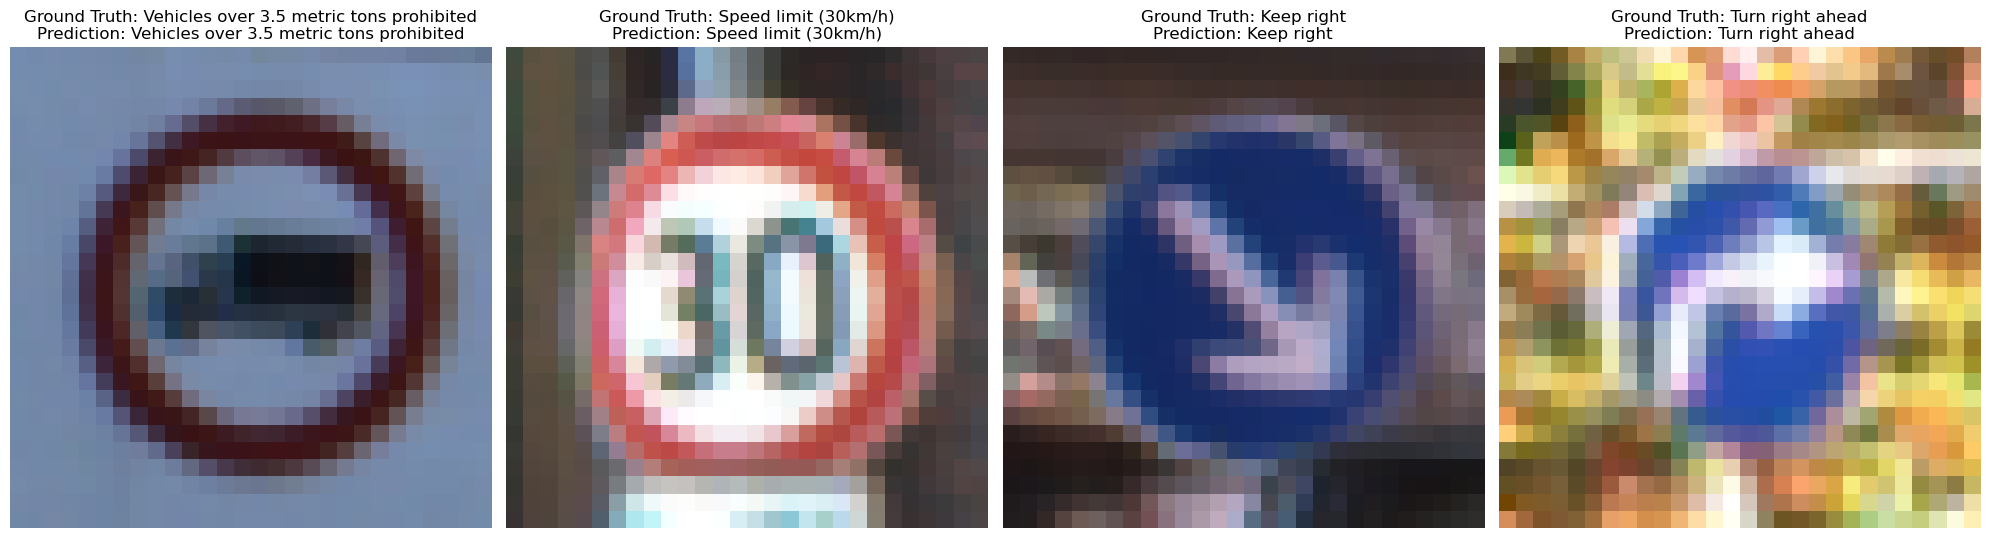

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9000791907310486     │
│         test_loss         │     6.388645172119141     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.388645172119141, 'test_acc': 0.9000791907310486}]

In [9]:
#checkpoint_task3 = torch.load('checkpoints_section_3/epoch=8-step=2997.ckpt')
#model_cnn.load_state_dict(checkpoint_task3['state_dict'])

# Test the model and report test accuracy and test loss
trainer_task.test(model_cnn)

<div class="alert alert-block alert-info">
    
## Task 3.5: Visualise the results and apply additional analysis here <a class="anchor" id="t3_5"></a>

Using log files and matplotlib, plot train loss, validation loss, train accuracy, and validation accuracy.

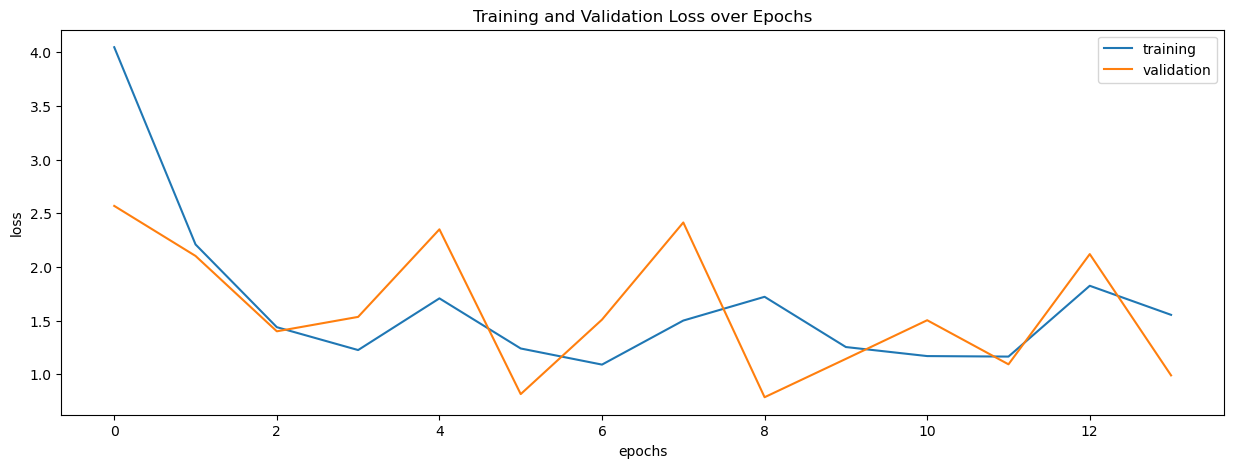

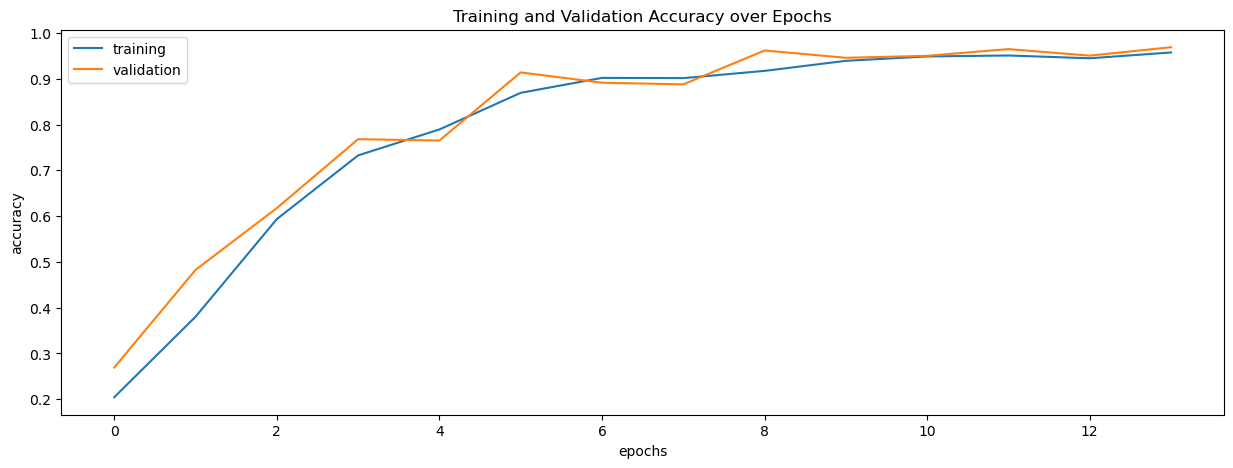

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


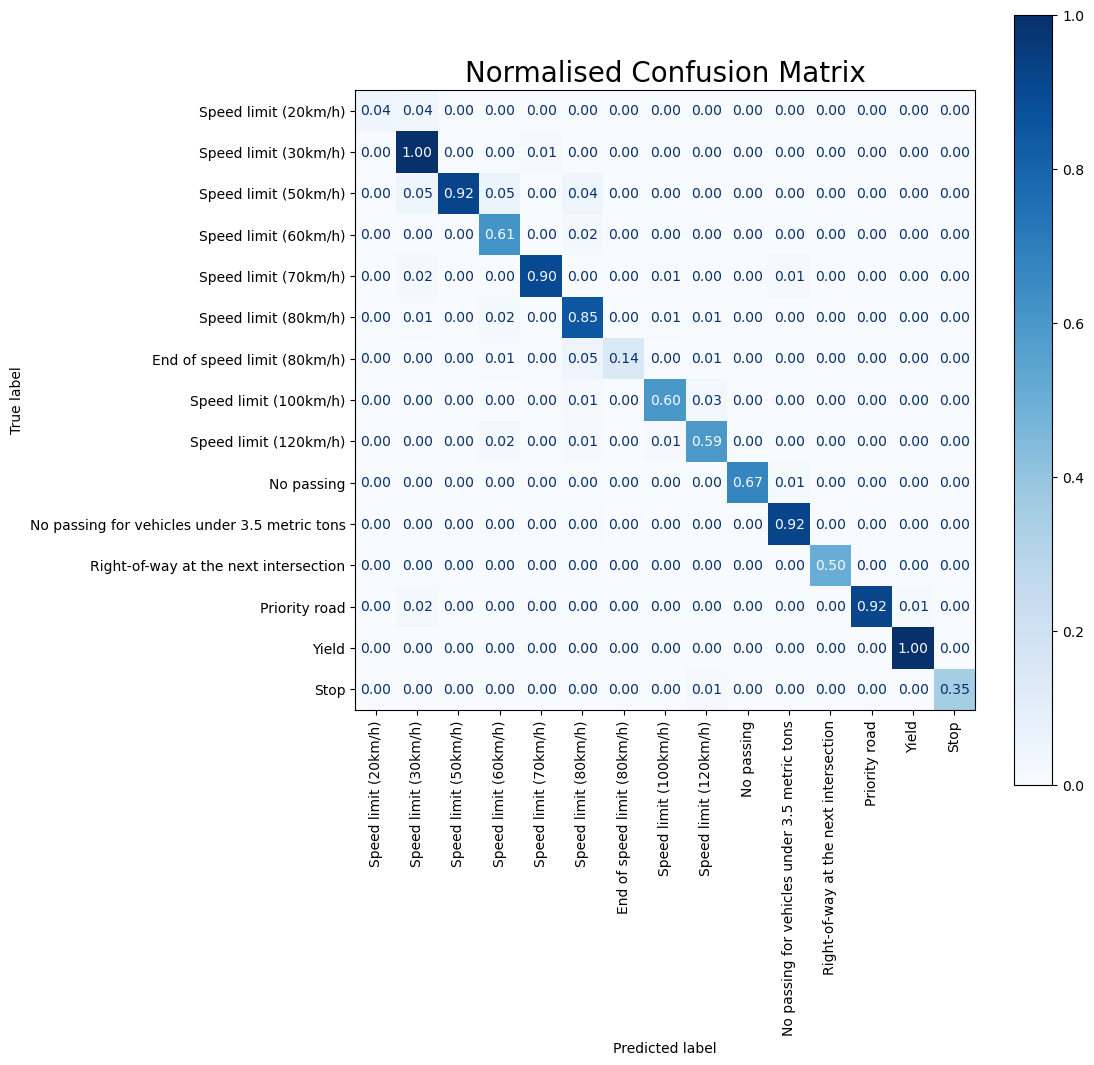

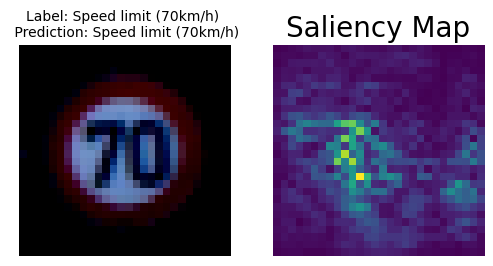

In [25]:
# Show the CNN training and validation curves.
# You can use your own way of logging if you do not want to use tensorboard.
metrics_task = pd.read_csv(trainer_task.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

# Create a figure with all the appropriate labels/titles etc.
train_loss = metrics_task["train_loss"]
val_loss = metrics_task["val_loss"]
plt.figure(0, figsize=(15,5))
plt.plot(train_loss[:-1], label="training")
plt.plot(val_loss[:-1], label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

# Create a figure with all the appropriate labels/titles etc.
train_acc = metrics_task["train_acc"]
val_acc = metrics_task["val_acc"]
plt.figure(1, figsize=(15,5))
plt.plot(train_acc[:-1], label="training")
plt.plot(val_acc[:-1], label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()


# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library
from torchmetrics import ConfusionMatrix
conf_mat_classes = 15
confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=conf_mat_classes)
model_cnn.eval() # Set the model to evaluation mode
# Loop through all batches in the testloader and fill out the confusion matrix
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        logits = model_cnn(inputs)
        preds = logits.argmax(dim=1)
        # only update the confusion matrix if the label and preds are less than 15
        idx = (labels.reshape(1, -1).numpy() < conf_mat_classes) & (preds.reshape(1, -1).numpy() < conf_mat_classes)
        confusion_matrix.update(preds[idx].cpu(), labels[idx].cpu())

# print the confusion matrix
# print(confusion_matrix.compute())
conf_max_val = np.max(confusion_matrix.compute().numpy())
# confusion_matrix_np = confusion_matrix.compute().numpy() / conf_max_val

from sklearn.metrics import ConfusionMatrixDisplay

# Create a ConfusionMatrixDisplay object from the ConfusionMatrix instance
cm_display = ConfusionMatrixDisplay(confusion_matrix.compute().numpy() / conf_max_val, display_labels=categories[:conf_mat_classes])

# Plot the confusion matrix, with large size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalised Confusion Matrix", fontsize = 20)
cm_display.plot(cmap='Blues', xticks_rotation='vertical', values_format='.2f', ax=ax)



# saliency map on a correctly predicted image
test_inputs, test_labels = next(iter(test_loader))
test_preds = model_cnn(test_inputs).argmax(dim=1)

# Find indices of correctly classified test samples
correct_indices = ((test_labels == test_preds))

# Select a random index from the correctly classified samples
index = np.random.choice(np.where(correct_indices)[0])

# Retrieve the input image, true label, model output, predicted label for the selected index
image = test_inputs[index]
label = test_labels[index]
prediction = test_preds[index]

# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
image = image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = model_cnn(image)
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]
score_max.backward() # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the maximum absolute gradient values across channels
# You can use .abs() and torch.max()
grads = image.grad.abs()
saliency_map, _ = torch.max(grads, dim=1)

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image with proper unnormalization
# Do this in the first subplot
axes[0].imshow((image[0].permute(1, 2, 0) * 0.5 + 0.5).detach().numpy()) # un-normalize
axes[0].axis("off")
title_text = f"Label: {categories[label]} \n Prediction: {categories[prediction]}"
axes[0].set_title(title_text, fontsize = 10)
# Display the saliency map
# Do this in the second subplot
axes[1].imshow(saliency_map[0].detach().numpy(), vmin=torch.min(saliency_map), vmax=torch.max(saliency_map)) # un-normalize
axes[1].axis("off")
axes[1].set_title("Saliency Map", fontsize = 20)

# Show the original image and saliency map side by side
plt.show()

Add in your other analysis here. You can choose two (or more) of the following (or any others that are not on this list):

- Feature maps at the outputs of each __CNN block__ for a correctly classified road sign
- Saliency map on a correctly classified road sign
- Top 5 incorrectly classified road signs
- Occlusion sensitivity on a few images
- Confusion matrix on a subset of classes (~15 classes)

<div class="alert alert-block alert-success">
    
## Task 3.6: Discussion Questions <a class="anchor" id="t3_6"></a>
    
## Questions
    
1. List the different ways you have tried to optimize your model and discuss why you chose those methods.

2. Show how you calculated the input size of the fully connected layer right after all the convolutional blocks. 

3. Please talk and discuss about the first additional analysis you have performed. What can you deduce from the analysis?

4. Please talk and discuss about the second additional analysis you have performed. What can you deduce from the analysis?
    

    
## Answers

1. I inserted batch normalisation after each conv block; This helps with convergence and learning speed, by converting all the dimensions of information into z-score space, which means they are all on the same order of magnitude, and the parameters may step in any direction effectively, during gradient descent. I inserted maxpool layers after that, which helps compress the information further and reduces the processing required for subsequent conv blocks. I added drop out to reduce the model's capacity to over-fit, increasing its generalisation abilities. 

2. The image starts as 3x28x28. The first convblock with padding returns 32 channels, hence 32x28x28. The maxpool halves the image dimensions in each channel. Hence 32x14x14. The second convblock with padding returns 128 channels, hence 128x14x14. The maxpool after that halves the images again, hence 128x7x7. The gap layer compresses the information in each channel as 3x3. So finally, each image has 128x3x3 = 1152 values, which will be the input size of the fully connected layer. 

3. The confusion matrix of the first 15 classes show that the model is poor at recognising 20km speed limit, and end of speed limit sign. By inspection, the end of speed limit sign has complex features like diagonal stripes obscuring a faint number underneath, which would understandably make it hard to recognise; the model is not rich enough to capture the obstruction well. However, the 20km sign doesn't seem that difficult to detect, and without plotting the confusion matrix of all classes, the other classes that are confused with 20km sign is unknown. The classes that are really well recognized - yield, priority road, no vehicles under 3.5t - are all very clear and simple shapes. 

4. The saliency map has a bright region on the left half of the 70km speed limit street sign. This suggests the number 7 on that sign is what affects the output the most. This makes sense because the 0 on the right is common among many speed limit signs like 20km, 30km... 
